# Plotting the solution to Binary Decision Models

## Introduction

In [1]:
include("BDM_Analytic.jl");
using .BDMAnalytic;

In [2]:
using Plots, LaTeXStrings, Distributions
Plots.theme(:dao)

In this notebook we show how to use our pre-made Julia packages in order to produce the time-dependent analytical solution to binary decision models of the type inspired by Kirman's model of ant rationality (Kirman, Alan. "Ants, rationality, and recruitment." The Quarterly Journal of Economics 108.1 (1993): 137-156) and the Moran model (Moran, Patrick Alfred Pierce. "Random processes in genetics." Mathematical proceedings of the cambridge philosophical society. Vol. 54. No. 1. Cambridge University Press, 1958).

Below we can output the solution for the following binary decision models:
1. Kirman's original model of ant rationality,

$$ L \xrightarrow{(N-n)\epsilon +\nu \frac{n (N-n)}{N-1}} R,\; R \xrightarrow{n\epsilon+\nu \frac{n (N-n)}{N-1}} L. $$
Here, $L$ and $R$ represents an ant at the left- and right-hand food source respectively, $N$ is the total number of ants, $n$ is the number of ants at the right-hand food source (i.e., the number of $R$s), $\epsilon$ is the rate of random switching, and $\nu$ is the rate at which any two ants meet each other.

2. Asymmetric noises $\epsilon_1$ and $\epsilon_2$ at each food source,

$$ L \xrightarrow{(N-n)\epsilon_1 +\nu \frac{n (N-n)}{N-1}} R,\; R \xrightarrow{n\epsilon_2+\nu \frac{n (N-n)}{N-1}} L. $$
This type of system was previously studied in Moran, José, et al. "From Ants to Fishing Vessels: A Simple Model for Herding and Exploitation of Finite Resources." Journal of Economic Dynamics and Control (2021): 104169.

3. Asymmetric noise and asymmetric strengths to attract ants to the opposing food source $\nu_1$ and $\nu_2$,

$$ L \xrightarrow{(N-n)\epsilon_1 +\nu_1 \frac{n (N-n)}{N-1}} R,\; R \xrightarrow{n\epsilon_2+\nu_2 \frac{n (N-n)}{N-1}} L. $$

In our paper we show how to solve of these models analytically and derive expressions (or equations) describing the timescales of the system (which are the eigenvalues of the master operator). We then use a method based on 
the resolvent of the master operator, which gives us the probabilities of ants being at each food source in time, a method that only requires the eigenvalues of the master operator.

Note that this code is based on a previous repo of the author and can be found at https://github.com/jamesholehouse/BinaryDecisionModel.

We define the binary decision model (BDM) `struct` below.

In [4]:
BD1 = BDM(pars = [1.0,1.0], N = 50); # ϵ=1.0, μ=1.0
BD2 = BDM(pars = [1.0,0.1,1.0], N = 50); # ϵ1=1.0, ϵ2 = 0.1, μ=1.0
BD3 = BDM(pars = [1.0,0.1,1.0,2.0], N = 50); # ϵ1=1.0, ϵ2 = 0.1, μ1=1.0, μ2=2.0

Note that the number of parameters chosen in `pars` specifies the type of ant model that we are solving for. We can then access certain field of the `struct`, for example the number of ants in the system.

In [5]:
BD1.N

50

To access the eigenvalues of each `BDM` simply type (remove `;` to print),

In [13]:
BD1.λ; # eigenvalues (relaxation rates) for BD1

To access the transition rate matrix simply type,

In [14]:
BD1.A; # transition rate matrix for BD1

Using the `prob(BDM, t, ic)` function we can then output the probability distributions for the model given the BDM at a time $t$ for an initial condition `ic`, below we do this for three different times. If we don't specify the starting condition, then is assumed that the system has an initial condition with $N/2$ up spins, or else setting `ic=m::Int64` will have an initial condition starting from $m$ up spins.

In [15]:
p1 = [prob(BD1, 0.1), prob(BD1, 1.0), prob(BD1, 4.0)];
p2 = [prob(BD2, 0.1), prob(BD2, 1.0), prob(BD2, 4.0)];
p3 = [prob(BD3, 0.1), prob(BD3, 1.0), prob(BD3, 4.0)];

One can then plot the probability distributions below, from just after the initial condition to towards the steady state.

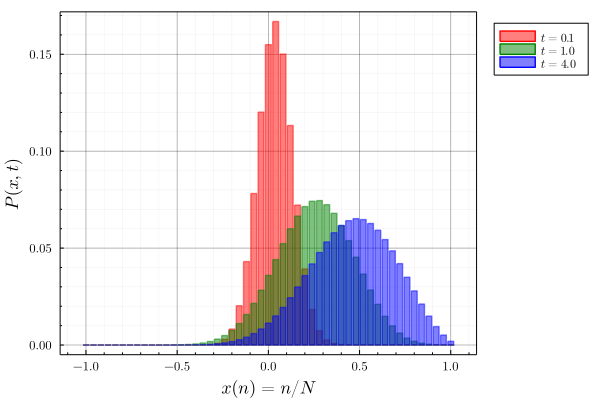

In [17]:
bar(p3, label = [L"t = 0.1" L"t = 1.0" L"t = 4.0"], color = ["red" "green" "blue"], linecolor = ["red" "green" "blue"], alpha = 0.5)
xlabel!(L"$x(n)=n/N$")
ylabel!(L"$P(x,t)$")

We can also check that the sum of the probabilities sums to 1 (or very close to 1 due to the numerical precision used) for each distribution. 

In [7]:
[sum(p3[i][2]) for i in 1:3]

3-element Vector{Double64}:
 1.0000000000000162
 1.0000000000000449
 1.0000000000001017

Oftentimes, the initial condition of the number of right voting deciding is not exactly known and is itself a probability distribution. For example, a common initial condition is that each agent initially decides right with probability $p_0 = 0.5$; in which case there is an initial binomial distribution of initial decisions over the number of agents. We can specify initial distributions when specifying `ic` in `prob()`.

In [8]:
p1_bin_id = prob(BD1, 1.0, Binomial(BD1.N,0.5));

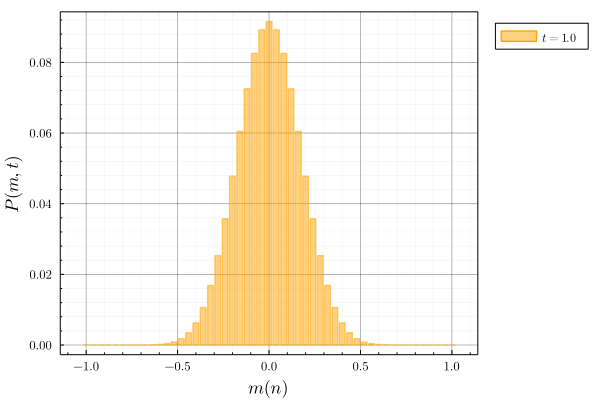

In [9]:
bar(p1_bin_id, label = L"t = 1.0", color = :orange, linecolor = :orange, alpha = 0.5)
xlabel!(L"$m(n)$")
ylabel!(L"$P(m,t)$")

Again check the normalisation.

In [10]:
sum(p1_bin_id[2])

1.0000000000000018

Finally, we can output the steady state distribution for an Ising model through `SSprob(BDM)`. No initial condition needs to be specified here since this is the *steady state* distribution reached as $t\to \infty$ and is hence independent of the initial condition. For $F=0$ we find that we obtain a bimodal steady-state distributions, where each mode corresponds to all agents either voting left or right. In the limit $N\to\infty$ this is known as symmetry breaking, since the time taken to transition between these modes of behaviour is exponentially large in $N$.

In [11]:
ps1 = SSprob(BD1);
ps2 = SSprob(BD2);
ps3 = SSprob(BD3);

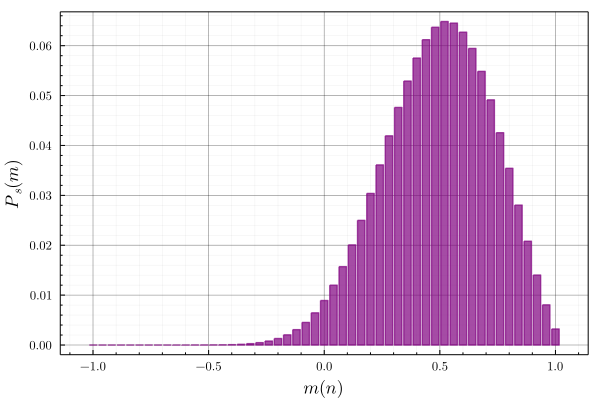

In [12]:
bar(ps3, color = :purple, linecolor = :purple, alpha = 0.7, legend=:none)
xlabel!(L"$m(n)$")
ylabel!(L"$P_s(m)$")

And finally, check the normalisation.

In [13]:
sum(ps1[2])

1.0

## Comparison to the SSA

Any analytical solution to a master equation can be verified by comparison to the stochastic simulation algorithm (SSA, see Gillespie, Daniel T. "Stochastic simulation of chemical kinetics." Annu. Rev. Phys. Chem. 58 (2007): 35-55). Below we show that our analytical solutions are in precise agreement with the SSA.

In [14]:
include("SSABinaryDecision.jl");
using .BinaryDecSSA;

In [15]:
SSA1 = BinDecMod(pars = [1.0,0.1,1.0,2.0], N = 50);
Ens1 = Ensemble(BD = SSA1, e_size = 2500, τₘ = 10^3, Δτ = 0.1)

Ensemble
  BD: BinDecMod
  e_size: Int64 2500
  τₘ: Int64 1000
  Δτ: Float64 0.1
  sims: Tuple{Vector{Float64}, Vector{Array{Real, N} where N}}


In [16]:
EnsProb(Ens1,10000)

(range(-1.0, stop=1.0, length=51), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.062, 0.0584, 0.046, 0.0492, 0.0376, 0.028, 0.024800000000000003, 0.0164, 0.0064, 0.0028])

In [17]:
pFC = [EnsProb(Ens1,2), EnsProb(Ens1,11), EnsProb(Ens1,41)];

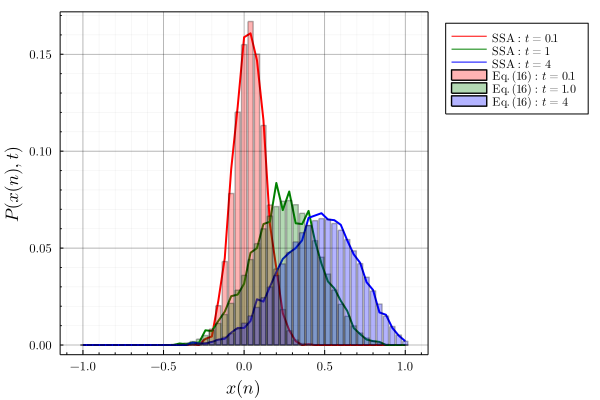

In [18]:
plot(pFC[1][1], [pFC[1][2], pFC[2][2], pFC[3][2]], lw = 2.0, label = [L"\mathrm{SSA:} t = 0.1"  L"\mathrm{SSA:}  t = 1"  L"\mathrm{SSA:} t = 4"], color = ["red" "green" "blue"])
bar!(p3, label = [L"\mathrm{Eq. (16):} t = 0.1"  L"\mathrm{Eq. (16):}  t = 1.0"  L"\mathrm{Eq. (16):} t = 4"], color = ["red" "green" "blue"], alpha = 0.3)
xlabel!(L"$x(n)$")
ylabel!(L"$P\,(x(n),t)$")

## How does relaxation timescale change with asymmetric $\mu_1$ and $\mu_2$?

A simple closed-form expression for the eigenvalues is not easily obtained where $\mu_1\neq \mu_2$. Let's investigate the change in the smallest magnitude non-zero eigenvalues $\lambda_1$ numerically. Let's set $N=50$, $\epsilon_1=\epsilon_2=1.0$, $\mu_1 = 1.0$ and vary $\mu_2 \in [0.1,10]$. Later on we can also investigate for other parameter sets. We define the relative asymmetry in the $\mu$s as the relative difference $\Delta = \frac{\mu_2-\mu_1}{\mu_1}.$

In [82]:
μ2vals1 = [i for i in 0.0:0.1:100];#[10^(i/100) for i in -200:1:100];
Δvals1 = (μ2vals1.-1.0)./1.0;
λvals1 = [Real(BDM(pars = [1.0,1.0,1.0,i], N = 50).λ[2]) for i in μ2vals1];

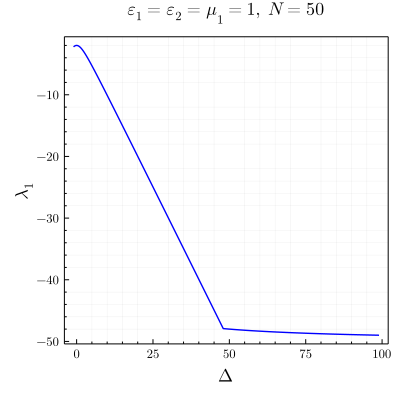

In [83]:
plot(Δvals1, λvals1, legend = :none, linecolor = :blue, grid = :none)
plot!(size = (400,400))
xlabel!(L"\Delta")
ylabel!(L"\lambda_1")
title!(L"\epsilon_1=\epsilon_2=\mu_1=1,\; N=50")

In [80]:
μ2vals2 = [i for i in 0.0:0.1:100];#[10^(i/100) for i in -200:1:100];
Δvals2 = (μ2vals2.-0.1)./0.1;
λvals2 = [Real(BDM(pars = [1.0,1.0,0.1,i], N = 50).λ[2]) for i in μ2vals2];

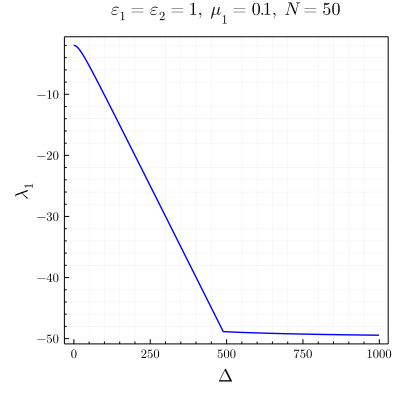

In [81]:
plot(Δvals2, λvals2, legend = :none, linecolor = :blue, grid = :none)
plot!(size = (400,400))
xlabel!(L"\Delta")
ylabel!(L"\lambda_1")
title!(L"\epsilon_1=\epsilon_2=1,\;\mu_1=0.1,\; N=50")

In [75]:
μ2vals3 = [i for i in 0.0:1.0:100];#[10^(i/100) for i in -200:1:100];
Δvals3 = (μ2vals3.-10.0)./10.0;
λvals3 = [Real(BDM(pars = [1.0,1.0,10.0,i], N = 50).λ[2]) for i in μ2vals3];

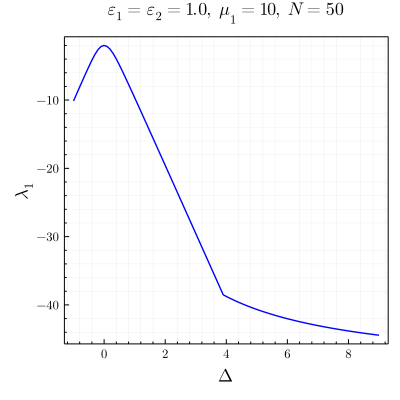

In [79]:
plot(Δvals3, λvals3, legend = :none, linecolor = :blue, grid = :none)
plot!(size = (400,400))
xlabel!(L"\Delta")
ylabel!(L"\lambda_1")
title!(L"\epsilon_1=\epsilon_2=1.0, \;\mu_1=10,\; N=50")